Stochastic Simulation Reproducibility
======================================

Theoretical Notes
------------------

By definition, a stochastic process is a sequence of random variables on the real line. Therefore, sampling a stochastic process at a given time is the same as sampling a random variable.

The distribution of a stochastic process is not unique. Therefore, we cannot expect that a given distribution uniquely identifies a stochastic process. However, the characteristic function (CF) of a stochastic process perfectly describes the distribution of the stochastic process at each sampling time. It is well known that the "empirical characteristic function" (ECF) constructed from realizations of a stochastic process tends towards the CF of the stochastic process as the number of realizations increases. Therefore, we can compare realizations of a stochastic process by comparing sufficiently accurate ECFs of those realizations. Plainly put, two sets of realizations of a stochastic model can be compared by comparing sufficiently accurate ECFs of the sets. 

Testing for reproducible results: when increasing the number of realizations of a stochastic process does not significantly change the ECFs constructed from those realizations, then the ECFs are a reliable (i.e., sufficiently accurate) approximation of the CF of the stochastic process at each measured time.

Testing for reproduced results: if $N$ realizations of a stochastic process produce an ECF that is a reliable approximation of the CF of the stochastic process at each measured time, then another set of $N$ realizations of the same stochastic process will produce the same ECFs. 

On Using Empirical Characteristic Functions (needs updated)
--------------------------------------------

An ECF is a function of an arbitrary variable. Hence, to demonstrate reproducible or reproduced results one must demonstrate sufficient similarity of sufficiently representative ECFs at each sample time. 

The first problem to address is how to unambiguously show convergence of the ECF by the modeler. The Kolmogrov-Smirnov (K-S) statistic suffices to measure similarity of two ECFs, however one needs to define the domain over which the ECF is evaluated at each sample time and the interval of evaluation. 

For any sample size, a modeler can choose a sufficiently small domain to produce an arbitrarily small K-S statistic. Likewise a modeler can choose a sufficiently large domain to produce an ECF that is everywhere near zero (with a sufficiently coarse interval of evaluation). Both cases are mitigated if the ECF is evaluated over a domain that is scaled such that the unique features of the ECF are sufficiently captured, which should be somehow related to the variance of the sample. 

Todo: try recasting the ECF using a standardized variable of the sampled variable. 

Workflows (needs updated)
----------

Proposed criteria for reproducibility of a stochastic ODE model

1. Sampling distributions of all stochastic variables should converge at all sample times with increasing sample size. 
2. Results distributions can be reproduced for all stochastic variables at all sample time points for the same sample size. 

Proposed workflow (modeler)

1. Run sample size $2N$ of a stochastic model while sampling the same stochastic variables and sample times for all sample replicates. 
2. Evenly divide the sample into two subsamples, each of size $N$. 
3. At each sample time, construct an ECF for each variable of both subsamples at each sample time. 
4. If the difference of the two ECFs for each variable at all sample times is below a threshold, then consider sample size $M$ sufficient to reproduce the simulation results, where $M \geq N$. Otherwise, increase $N$ and return to 1. 

Proposed workflow (curator)

1. Implement the reported model. 
2. Generate a sample of size $M$.
3. At each reported sample time, construct an ECF for each variable. 
4. If the difference of the generated and reported ECFs for each variable at all sample times is below a threshold, then consider the curated model reproduced. 

This example uses a simple "SIR" model of viral infection. The model is a system of ordinary differential equations that describes the infection of a population of susceptible cells $S$ by a virus $V$. Infection turns susceptible cells into infected cells $I$, which release virus and later become recovered cells $R$. Recovered cells do not release virus and are not susceptible to infection. 

$$
\frac{dS}{dt} = - \beta S V \\
\frac{dI}{dt} = \beta S V - \delta I \\
\frac{dR}{dt} = \delta I \\
\frac{dV}{dt} = p I - k V
$$

This example introduces variations through random sampling of the infectivity parameter $\beta$ using a normal distribution.

In [1]:
import ipywidgets as ipw
from IPython.display import display

from stochastic_repro import start_pool
from stochastic_models import model_sir
from stochastic_tests import Test

t_fin = 10.0
num_steps = 100

test = Test(model=model_sir({'beta': ('norm', (2.0E-6, 0.2E-6))}),
            t_fin=t_fin, 
            num_steps=num_steps,
            sample_times=[t_fin / num_steps * i for i in range(0, num_steps + 1)],
            trials=[10, 100, 1000, 10000],
            stochastic=False)

The SIR model is characterized by transition of susceptible cells to infected cells and then to refractory cells, and a peak in virus that correlates with the peak in infected cells. 

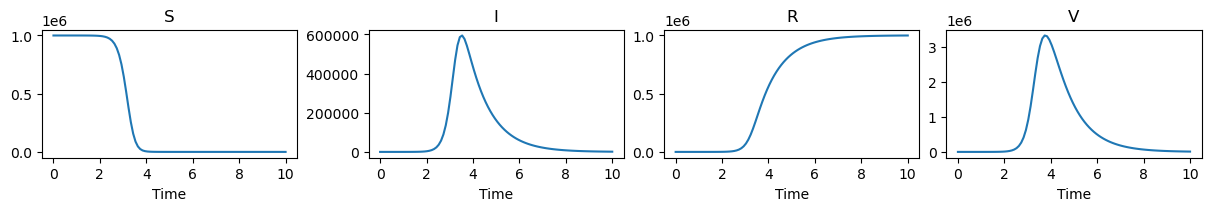

In [2]:
test.execute_deterministic()
_ = test.plot_results_deterministic()

As we increase the number of replicates, we should find that statistical measures of the replicates in time converge. 

In [3]:
label, out = ipw.Label(), ipw.Output()
display(out)
with out:
    display(label)

start_pool()
test.execute_stochastic(label)
_ = out.clear_output()

Output()

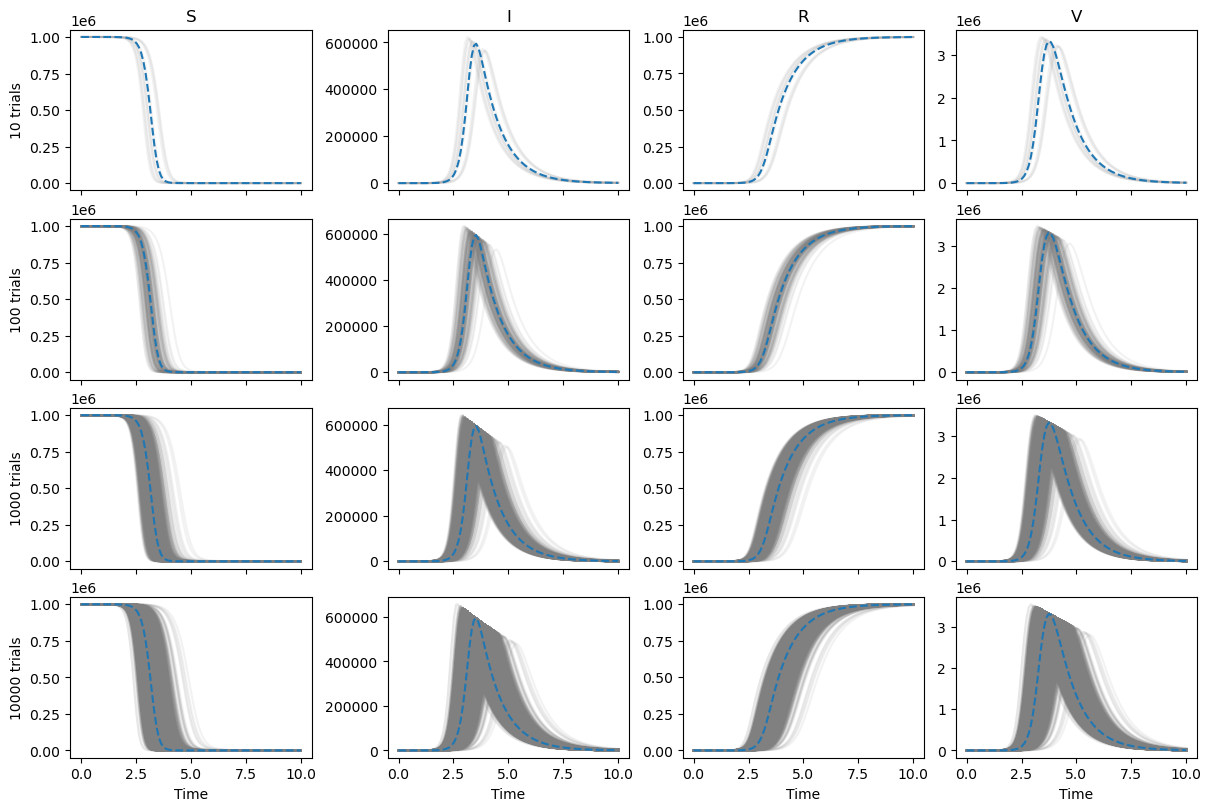

In [4]:
_ = test.plot_results_stochastic()

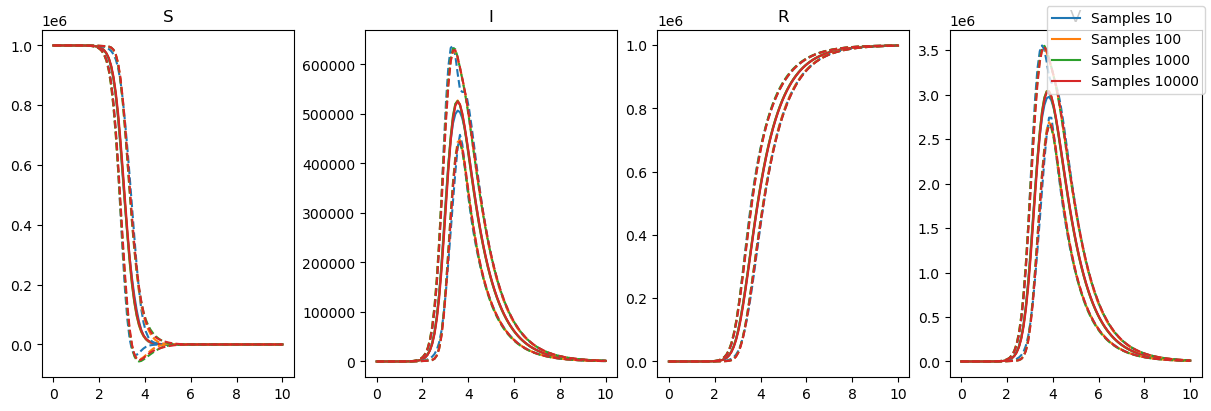

In [5]:
_ = test.plot_stats()

If we bin replicate results at each sample time, we should find that the probability distribution function of a variable at each time point converges with increasing number of replicates. 

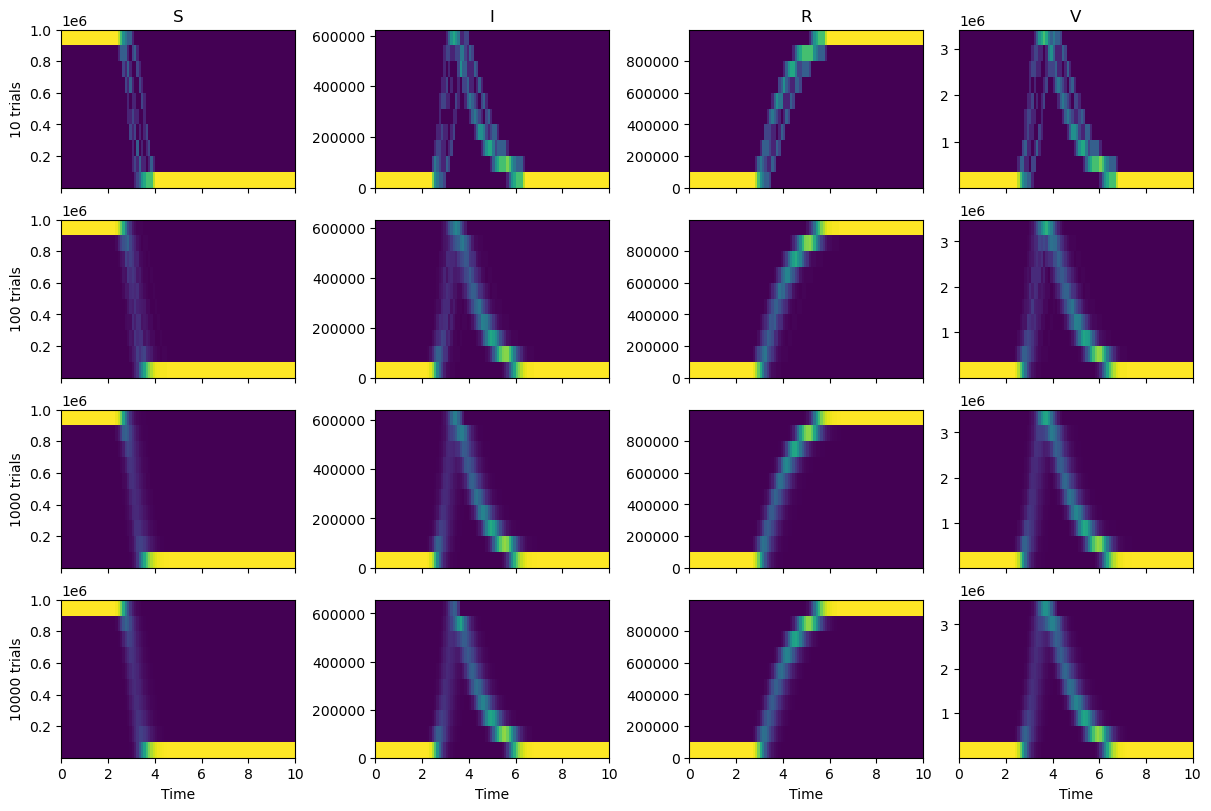

In [6]:
_ = test.plot_distributions()

A measure of convergence could be to calculate the average absolute relative difference in probability of each bin at each sampled time, where the change is taken with respect to the minimum of two compared probabilities. The basic procedure to calculate this metric for a set of replicates is as follows:

1. Evenly divide the set of replicates into two subsets. 
2. For each variable and sampled time, calculate an approximate probability distribution function for each subset using a typical histogram algorithm. Note that binning of each subset must use the same intervals. 
3. For each interval, calculate the maximum absolute relative difference between the approximate probability distribution function of each subset. The maximum is determined by calculating the difference relative to the lesser of the two probabilities of the interval. 
4. Take the mean of 3. over all intervals and sampled times to quantify the change for a variable. 

In [7]:
# progress_bar, out = ipw.IntProgress(), ipw.Output()
# progress_bar.max = (len(test.trials) - 1) * len(test.model.results_names)
# display(out)

# with out:
#     label = ipw.Label(value='Calculating differences...')
#     vbox = ipw.VBox([label, progress_bar])
#     display(vbox)

# test.measure_dist_diff_basic(progress_bar=progress_bar)
# out.clear_output()

# _ = test.plot_dist_diff(test.acc_diff_basic[0.0])

However, this metric does not seem to capture the similarity between two subsets of a set of replicates. For example, the final number of replicates seems to be sufficiently similar by inspection. 

In [8]:
# _ = test.plot_distributions_compare(test.trials[-1])

Applying a filter produces a metric that shows convergence. In this case, the probabilities of a variable at a sample time are not compared if the minimum of the two probabilities is below a threshold. 

In [9]:
# progress_bar, out = ipw.IntProgress(), ipw.Output()
# progress_bar.max = (len(test.trials) - 1) * len(test.model.results_names)
# display(out)

# with out:
#     label = ipw.Label(value='Calculating differences...')
#     vbox = ipw.VBox([label, progress_bar])
#     display(vbox)

# test.measure_dist_diff_basic(filter=0.05, progress_bar=progress_bar)
# out.clear_output()

# _ = test.plot_dist_diff(test.acc_diff_basic[0.05])

Kullback-Leibler Divergence might be a viable comparator

In [10]:
# progress_bar, out = ipw.IntProgress(), ipw.Output()
# progress_bar.max = len(test.trials) * len(test.model.results_names)
# display(out)

# with out:
#     label = ipw.Label(value='Calculating differences...')
#     vbox = ipw.VBox([label, progress_bar])
#     display(vbox)

# test.measure_dist_div_kldiv(progress_bar=progress_bar)
# out.clear_output()

# _ = test.plot_dist_diff(test.acc_diff_kl_div)

Testing for correlation between results sets might be a viable comparator. 

In [11]:
# out = ipw.Output()
# display(out)

# with out:
#     print('Analyzing correlations...')
# test.measure_correlation()
# out.clear_output()

# _ = test.plot_correlations()

Testing various standard tests here, looking for a way to assign a p-value to showing reproducibility. None of them seem to work well. 

In [12]:
# import numpy as np
# from matplotlib import pyplot as plt
# from scipy import stats


In [13]:
# # Testing the relevance of the Kolmogorov–Smirnov test


# def ks_test(res_1: np.ndarray, res_2: np.ndarray):
#     return abs(stats.ks_2samp(res_1, res_2).statistic)


# def ks_test_pval(res_1: np.ndarray, res_2: np.ndarray):
#     return stats.ks_2samp(res_1, res_2).pvalue


# conv_measure_ks_test = {name: {trial: list() for trial in test.trials} for name in test.model.results_names}
# conv_measure_ks_pval = {name: {trial: list() for trial in test.trials} for name in test.model.results_names}

# for name in test.model.results_names:
#     for trial in test.trials:
#         n = int(trial / 2)
#         for sample_time in test.sample_times:
#             res = test.sims_s[trial].extract_var_time(name, sample_time)
#             res_1, res_2 = res[:n], res[n:]
#             conv_measure_ks_test[name][trial].append(ks_test(res_1, res_2))
#             conv_measure_ks_pval[name][trial].append(ks_test_pval(res_1, res_2))

# fig, ax = plt.subplots(len(test.trials), len(test.model.results_names), sharey=False, figsize=(12.0, 2.0 * len(test.trials)), layout='compressed')

# for i, trial in enumerate(test.trials):
#     for j, name in enumerate(test.model.results_names):
#         res = conv_measure_ks_test[name][trial]
#         ax[i][j].plot(test.sample_times, res)
#     ax[i][0].set_ylabel(f'Trials: {trial}')
# for j, name in enumerate(test.model.results_names):
#     ax[0][j].set_title(name)
# fig.suptitle('Kolmogorov–Smirnov test (values)')

# fig, ax = plt.subplots(len(test.trials), len(test.model.results_names), sharey=True, figsize=(12.0, 2.0 * len(test.trials)), layout='compressed')

# for i, trial in enumerate(test.trials):
#     for j, name in enumerate(test.model.results_names):
#         res = conv_measure_ks_pval[name][trial]
#         ax[i][j].plot(test.sample_times, res)
#     ax[i][0].set_ylabel(f'Trials: {trial}')
#     ax[i][0].set_ylim(-0.05, 1.05)
# for j, name in enumerate(test.model.results_names):
#     ax[0][j].set_title(name)
# _ = fig.suptitle('Kolmogorov–Smirnov test (p-values)')

In [14]:
# # Testing the relevance of the Student t-test


# def t_test(res_1: np.ndarray, res_2: np.ndarray):
#     return abs(stats.ttest_ind(res_1, res_2).statistic)


# def t_test_pval(res_1: np.ndarray, res_2: np.ndarray):
#     return stats.ttest_ind(res_1, res_2).pvalue


# conv_measure_t_test = {name: {trial: list() for trial in test.trials} for name in test.model.results_names}
# conv_measure_t_pval = {name: {trial: list() for trial in test.trials} for name in test.model.results_names}

# for name in test.model.results_names:
#     for trial in test.trials:
#         n = int(trial / 2)
#         for sample_time in test.sample_times:
#             res = test.sims_s[trial].extract_var_time(name, sample_time)
#             res_1, res_2 = res[:n], res[n:]
#             conv_measure_t_test[name][trial].append(t_test(res_1, res_2))
#             conv_measure_t_pval[name][trial].append(t_test_pval(res_1, res_2))

# fig, ax = plt.subplots(len(test.trials), len(test.model.results_names), sharey=False, figsize=(12.0, 2.0 * len(test.trials)), layout='compressed')

# for i, trial in enumerate(test.trials):
#     for j, name in enumerate(test.model.results_names):
#         ax[i][j].plot(test.sample_times, conv_measure_t_test[name][trial])
#         ax[i][j].set_yscale('log')
        
#     ax[i][0].set_ylabel(f'Trials: {trial}')
# for j, name in enumerate(test.model.results_names):
#     ax[0][j].set_title(name)
# fig.suptitle('T-test (values)')

# fig, ax = plt.subplots(len(test.trials), len(test.model.results_names), sharey=True, figsize=(12.0, 2.0 * len(test.trials)), layout='compressed')

# for i, trial in enumerate(test.trials):
#     for j, name in enumerate(test.model.results_names):
#         ax[i][j].plot(test.sample_times, conv_measure_t_pval[name][trial])
#     ax[i][0].set_ylabel(f'Trials: {trial}')
#     ax[i][0].set_ylim(-0.05, 1.05)
# for j, name in enumerate(test.model.results_names):
#     ax[0][j].set_title(name)
# _ = fig.suptitle('T-test (p-values)')

In [15]:
# # Testing the relevance of the Cramér-von Mises test


# def cvm_test(res_1: np.ndarray, res_2: np.ndarray):
#     return abs(stats.cramervonmises_2samp(res_1, res_2).statistic)


# def cvm_test_pval(res_1: np.ndarray, res_2: np.ndarray):
#     return stats.cramervonmises_2samp(res_1, res_2).pvalue


# conv_measure_t_test = {name: {trial: list() for trial in test.trials} for name in test.model.results_names}
# conv_measure_t_pval = {name: {trial: list() for trial in test.trials} for name in test.model.results_names}

# for name in test.model.results_names:
#     for trial in test.trials:
#         n = int(trial / 2)
#         for sample_time in test.sample_times:
#             res = test.sims_s[trial].extract_var_time(name, sample_time)
#             res_1, res_2 = res[:n], res[n:]
#             conv_measure_t_test[name][trial].append(cvm_test(res_1, res_2))
#             conv_measure_t_pval[name][trial].append(cvm_test_pval(res_1, res_2))

# fig, ax = plt.subplots(len(test.trials), len(test.model.results_names), sharey=False, figsize=(12.0, 2.0 * len(test.trials)), layout='compressed')

# for i, trial in enumerate(test.trials):
#     for j, name in enumerate(test.model.results_names):
#         ax[i][j].plot(test.sample_times, conv_measure_t_test[name][trial])
#         ax[i][j].set_yscale('log')
        
#     ax[i][0].set_ylabel(f'Trials: {trial}')
# for j, name in enumerate(test.model.results_names):
#     ax[0][j].set_title(name)
# fig.suptitle('Cramér-von Mises test (values)')

# fig, ax = plt.subplots(len(test.trials), len(test.model.results_names), sharey=True, figsize=(12.0, 2.0 * len(test.trials)), layout='compressed')

# for i, trial in enumerate(test.trials):
#     for j, name in enumerate(test.model.results_names):
#         ax[i][j].plot(test.sample_times, conv_measure_t_pval[name][trial])
#     ax[i][0].set_ylabel(f'Trials: {trial}')
#     ax[i][0].set_ylim(-0.05, 1.05)
# for j, name in enumerate(test.model.results_names):
#     ax[0][j].set_title(name)
# _ = fig.suptitle('Cramér-von Mises test (p-values)')

In [16]:
# # Testing the relevance of the Kruskal-Wallis H-test


# def kwh_test(res_1: np.ndarray, res_2: np.ndarray):
#     return abs(stats.kruskal(res_1, res_2).statistic)


# def kwh_test_pval(res_1: np.ndarray, res_2: np.ndarray):
#     return stats.kruskal(res_1, res_2).pvalue


# conv_measure_t_test = {name: {trial: list() for trial in test.trials} for name in test.model.results_names}
# conv_measure_t_pval = {name: {trial: list() for trial in test.trials} for name in test.model.results_names}

# for name in test.model.results_names:
#     for trial in test.trials:
#         n = int(trial / 2)
#         for sample_time in test.sample_times[1:]:
#             res = test.sims_s[trial].extract_var_time(name, sample_time)
#             res_1, res_2 = res[:n], res[n:]
#             conv_measure_t_test[name][trial].append(kwh_test(res_1, res_2))
#             conv_measure_t_pval[name][trial].append(kwh_test_pval(res_1, res_2))

# fig, ax = plt.subplots(len(test.trials), len(test.model.results_names), sharey=False, figsize=(12.0, 2.0 * len(test.trials)), layout='compressed')

# for i, trial in enumerate(test.trials):
#     for j, name in enumerate(test.model.results_names):
#         ax[i][j].plot(test.sample_times[1:], conv_measure_t_test[name][trial])
#         ax[i][j].set_yscale('log')
        
#     ax[i][0].set_ylabel(f'Trials: {trial}')
# for j, name in enumerate(test.model.results_names):
#     ax[0][j].set_title(name)
# fig.suptitle('Kruskal-Wallis H-test (values)')

# fig, ax = plt.subplots(len(test.trials), len(test.model.results_names), sharey=True, figsize=(12.0, 2.0 * len(test.trials)), layout='compressed')

# for i, trial in enumerate(test.trials):
#     for j, name in enumerate(test.model.results_names):
#         ax[i][j].plot(test.sample_times[1:], conv_measure_t_pval[name][trial])
#     ax[i][0].set_ylabel(f'Trials: {trial}')
#     ax[i][0].set_ylim(-0.05, 1.05)
# for j, name in enumerate(test.model.results_names):
#     ax[0][j].set_title(name)
# _ = fig.suptitle('Kruskal-Wallis H-test (p-values)')

In [17]:
# # Testing the relevance of the Anderson-Darling test


# def ad_test(res_1: np.ndarray, res_2: np.ndarray):
#     return abs(stats.anderson_ksamp([res_1, res_2]).statistic)


# def ad_test_pval(res_1: np.ndarray, res_2: np.ndarray):
#     return stats.anderson_ksamp([res_1, res_2]).pvalue


# conv_measure_t_test = {name: {trial: list() for trial in test.trials} for name in test.model.results_names}
# conv_measure_t_pval = {name: {trial: list() for trial in test.trials} for name in test.model.results_names}

# for name in test.model.results_names:
#     for trial in test.trials:
#         n = int(trial / 2)
#         for sample_time in test.sample_times[1:]:
#             res = test.sims_s[trial].extract_var_time(name, sample_time)
#             res_1, res_2 = res[:n], res[n:]
#             conv_measure_t_test[name][trial].append(ad_test(res_1, res_2))
#             conv_measure_t_pval[name][trial].append(ad_test_pval(res_1, res_2))

# fig, ax = plt.subplots(len(test.trials), len(test.model.results_names), sharey=False, figsize=(12.0, 2.0 * len(test.trials)), layout='compressed')

# for i, trial in enumerate(test.trials):
#     for j, name in enumerate(test.model.results_names):
#         ax[i][j].plot(test.sample_times[1:], conv_measure_t_test[name][trial])
#         ax[i][j].set_yscale('log')
        
#     ax[i][0].set_ylabel(f'Trials: {trial}')
# for j, name in enumerate(test.model.results_names):
#     ax[0][j].set_title(name)
# fig.suptitle('Anderson-Darling test (values)')

# fig, ax = plt.subplots(len(test.trials), len(test.model.results_names), sharey=True, figsize=(12.0, 2.0 * len(test.trials)), layout='compressed')

# for i, trial in enumerate(test.trials):
#     for j, name in enumerate(test.model.results_names):
#         ax[i][j].plot(test.sample_times[1:], conv_measure_t_pval[name][trial])
#     ax[i][0].set_ylabel(f'Trials: {trial}')
#     ax[i][0].set_ylim(-0.05, 1.05)
# for j, name in enumerate(test.model.results_names):
#     ax[0][j].set_title(name)
# _ = fig.suptitle('Anderson-Darling test (p-values)')

The first plot shows ECFs for each variable and number of trials. Top row shows the real components. Bottom row shows the imaginary components. 

The second plot shows a well-known metrics for comparing distributions, applied to the modeler workflow described at the beginning of this notebook. 

The third and fourth plots show the real and imaginary components of the ECF for evenly divided samples of each set of trials, as in the modeler workflow described at the beginning of this notebook. 

In [18]:
test.find_ecfs()
test.measure_ecf_diffs()

In [19]:
for t in test.trials:
    ecf_ks_stat_t = {n: -1 for n in test.model.results_names}
    for ks in test.ecf_ks_stat[t]:
        for n, ks_stat in ks.items():
            ecf_ks_stat_t[n] = max(ecf_ks_stat_t[n], ks_stat)
    print(f'{t} trials')
    for n, ks_stat in ecf_ks_stat_t.items():
        print(f'\t{n}: {ks_stat}')

10 trials
	S: 1.2157357452684352
	I: 1.3726349813603638
	R: 1.3714374737579267
	V: 1.4040804999214778
100 trials
	S: 0.493673218685063
	I: 0.47328987761292607
	R: 0.43894516097354713
	V: 0.524663297190665
1000 trials
	S: 0.18183591043998998
	I: 0.18433093291943828
	R: 0.17442780264086283
	V: 0.18812680041021915
10000 trials
	S: 0.04460519949574094
	I: 0.04882979837708138
	R: 0.04542155657403958
	V: 0.04626927627093425


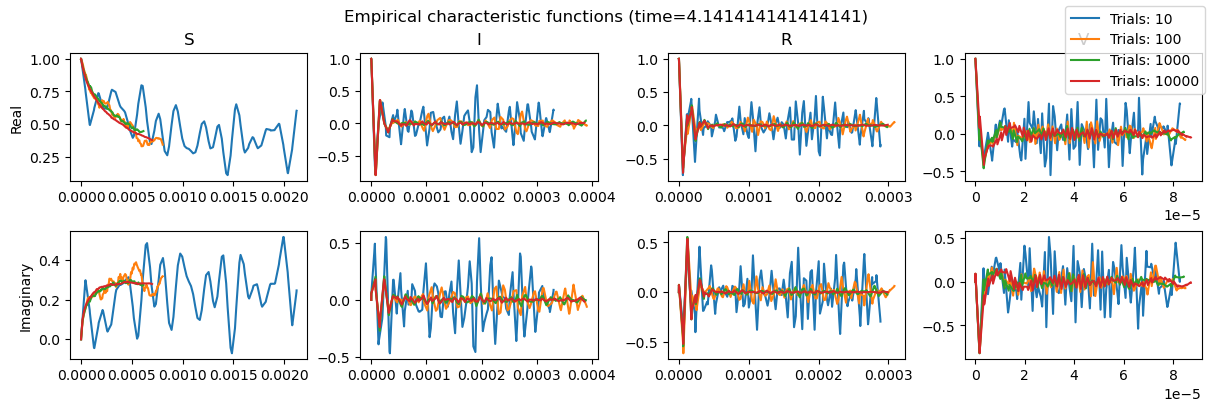

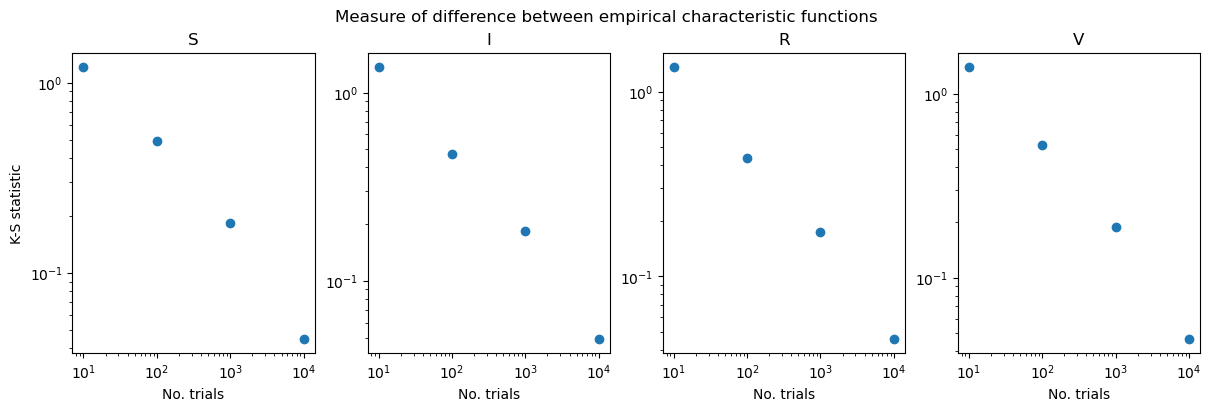

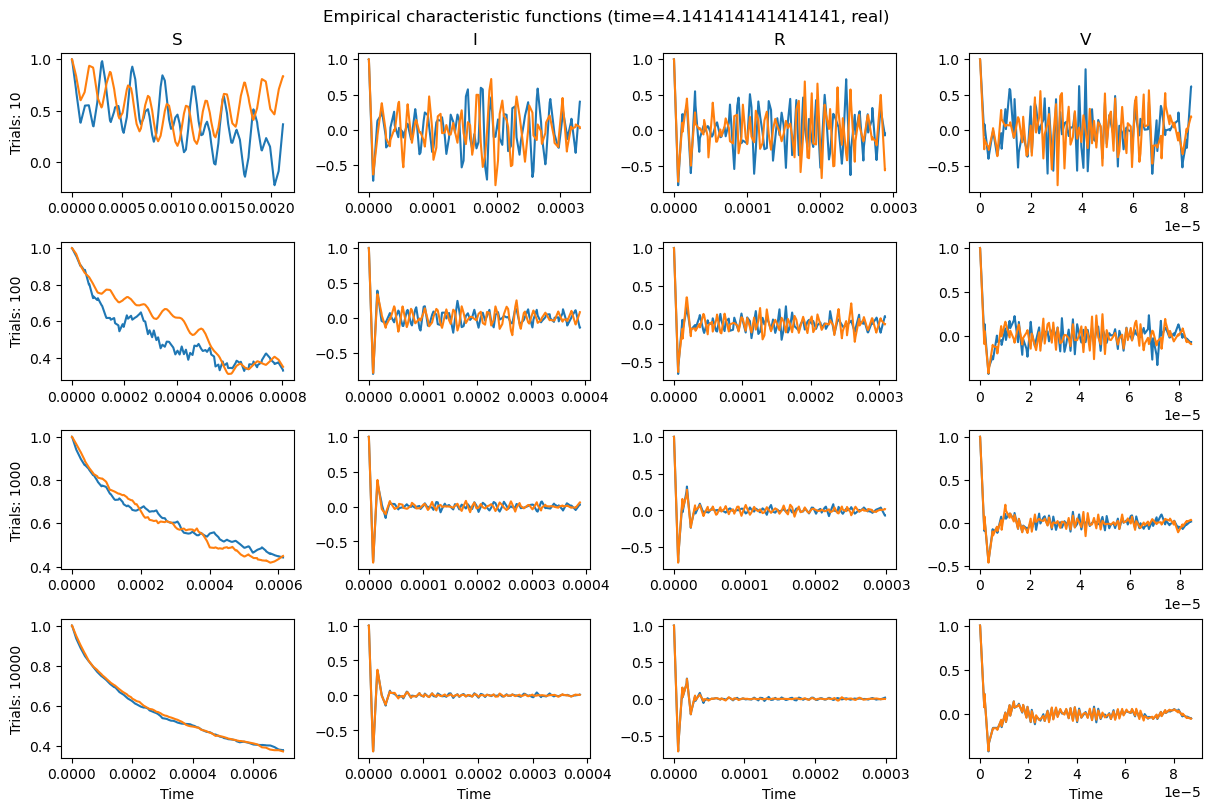

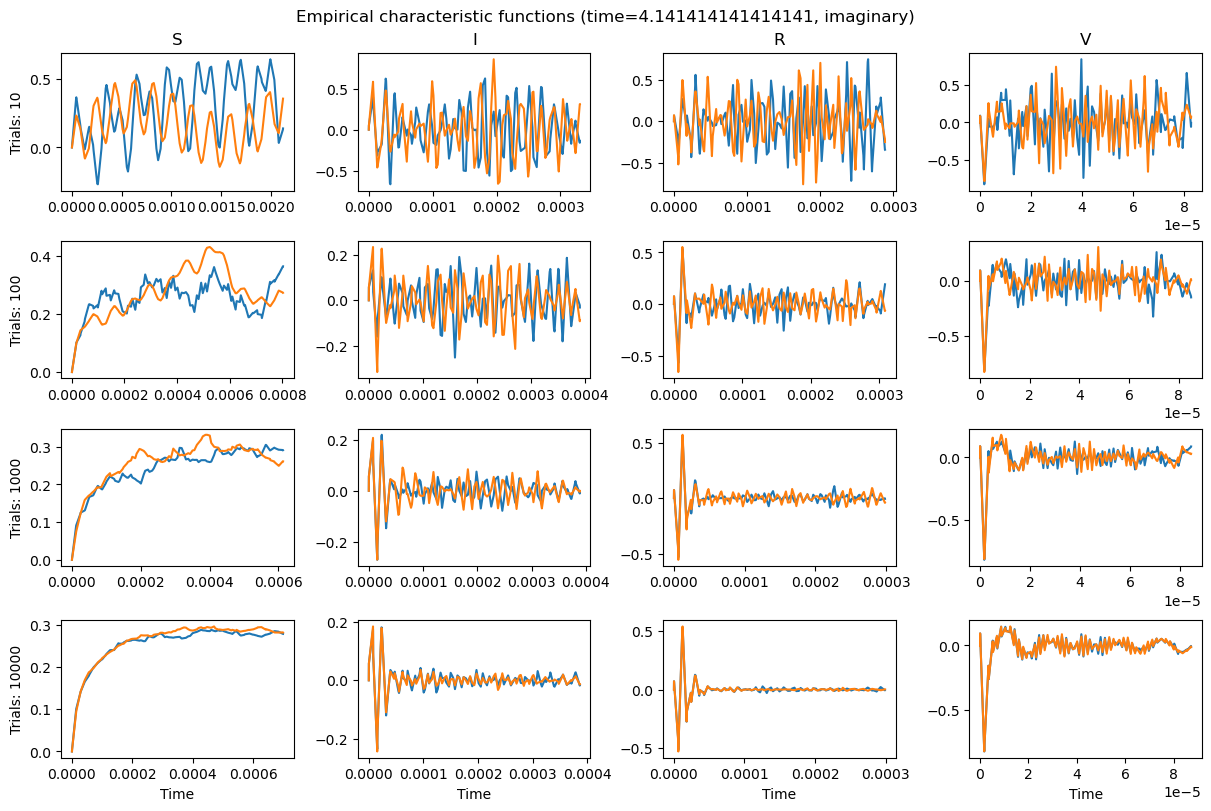

In [20]:
preview_time = test.max_ks_stat_time(test.trials[-1])
# preview_time = test.min_final_eval_time(test.trials[-1])

test.plot_ecf(time=preview_time)
test.plot_ecf_diffs()
_ = test.plot_ecf_comparison(time=preview_time)

It also seems that we can provide predictions about how many samples are required to reach a certain convergence metric as samples are collected. When performing the so-called "modeler workflow", the Kolmogrov-Smirnov statistic seems to fit well to a power law as a function of the total number of replicates in the two sets of replicates, 

$$
D \left( N \right) = a N ^ b
$$

This simulates the process of iteratively increasing the number of replicates and producing new predictions of the Kolmogrov-Smirnov statistic at each iteration: 

In [21]:
test.generate_ecf_diff_fits()

/Users/timothy.sego/Desktop/Current/stochastic_repro/stochastic_repro.py:992: OptimizeWarning: Covariance of the parameters could not be estimated
  return curve_fit(fit_func, data_x, data_y, **kwargs)


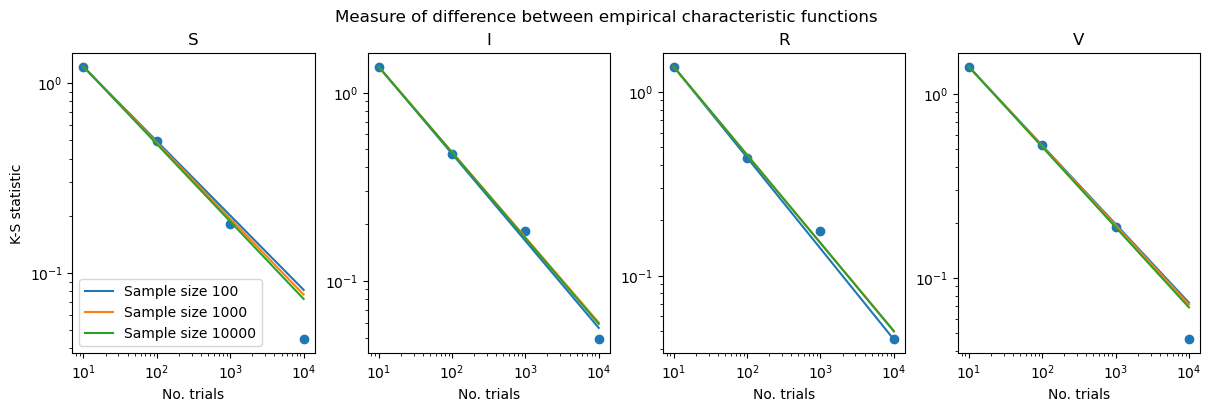

In [22]:
_, axs = test.plot_ecf_diff_fits(test.plot_ecf_diffs())
_ = axs[0].legend()

Matthias pointed out that the K-S statistic might be sensitive to how a sample is divided when testing for similarity. 

We find that Matthias was correct. The test for reproducibility should perform the same test repeatedly until a mean K-S statistic converges, which should be the reported final statistic for reproducibility. When the mean converges and the mean plus some amount of the standard deviation is below a threshold, consider the sample size sufficient for reproducibility. 

In [23]:
# Runtime: ~17 minutes (M1 max)
test.test_sampling(err_thresh=1E-3)

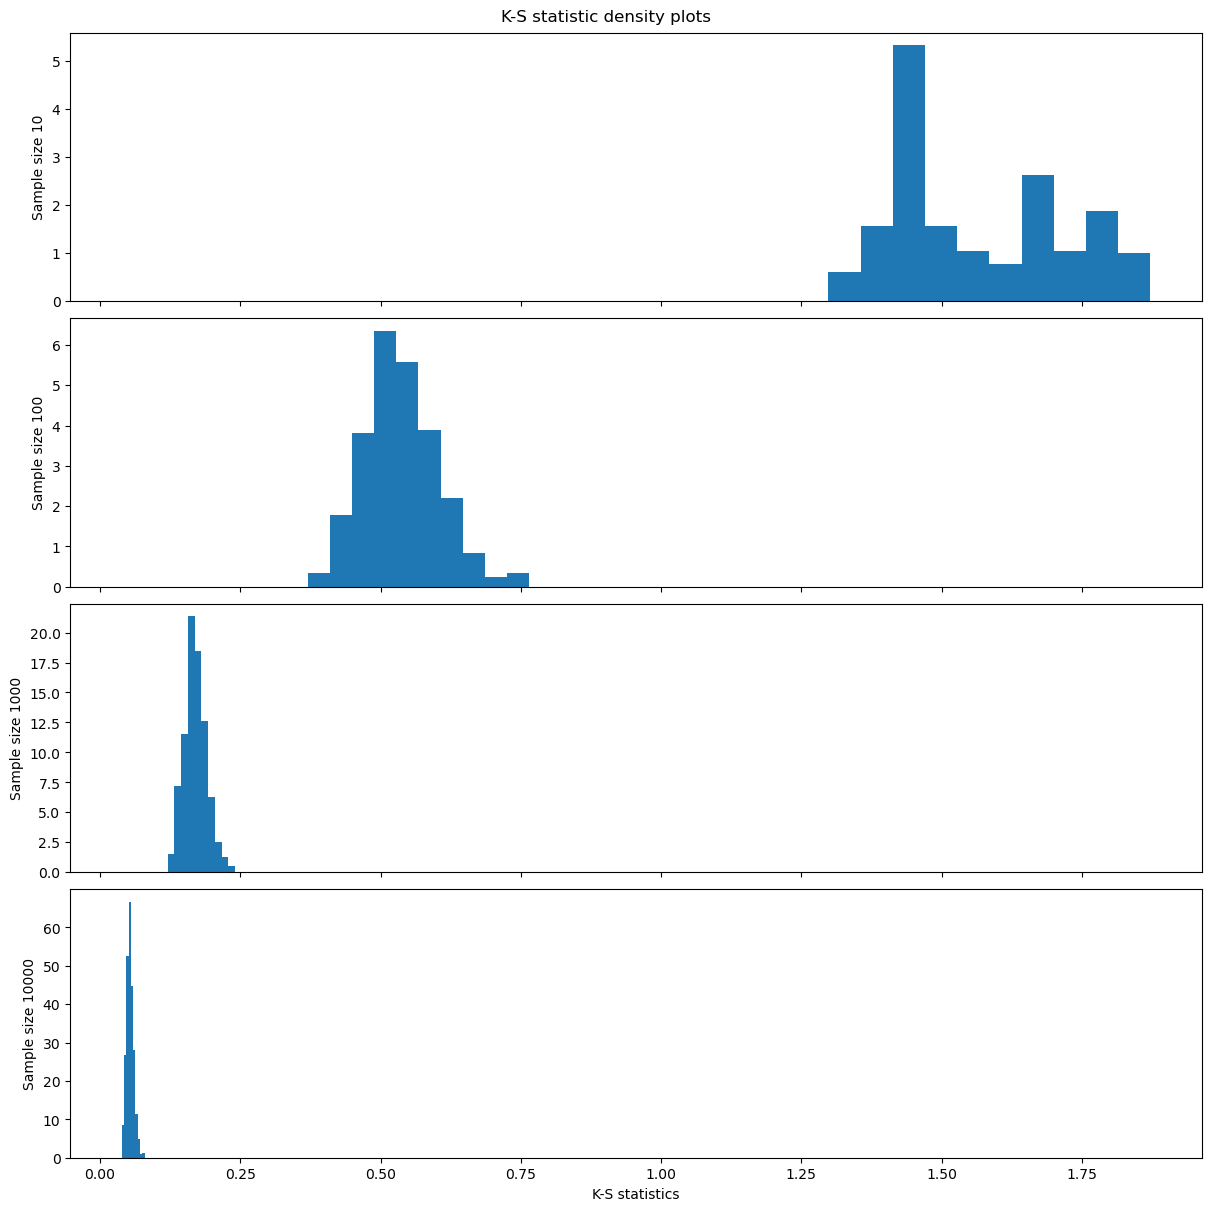

In [24]:
_ = test.plot_ks_sampling()

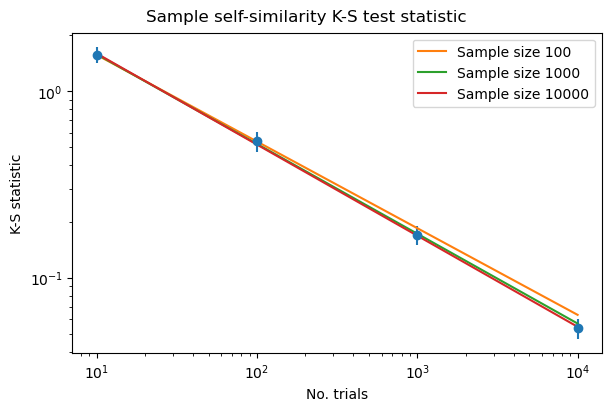

In [25]:
test.generate_ecf_sampling_fits()
_, ax = test.plot_ecf_sampling_fits(test.plot_ecf_sampling())
_ = ax.legend()